In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
embedding_dim = 32

In [3]:
mnist = tf.keras.datasets.mnist

In [4]:
(x_train, _),(x_test, _) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")
#x_train = x_train[0:1000, :, :, :]
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [5]:
image_dim = x_train.shape[1:]

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(256)

test_ds = tf.data.Dataset.from_tensor_slices(x_test).batch(256)

In [28]:
class Encoder(Model):
    def __init__(self, embedding_dim, layer_size = 128):
        super(Encoder, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(layer_size, activation='relu')
        self.d2 = Dense(embedding_dim, activation='relu')
    
    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

# Instantiate encoder

In [29]:
encoder = Encoder(embedding_dim=embedding_dim)
#tf.keras.utils.plot_model(encoder)

In [30]:
minitest = x_test[0:50, :, :]
minitest.shape, x_test.shape

((50, 28, 28, 1), (10000, 28, 28, 1))

In [31]:
encoder_test =  encoder(minitest )
encoder_test.shape

TensorShape([50, 32])

In [32]:
class Decoder(tf.keras.Model):
    def __init__(self, output_dim):
        super(Decoder, self).__init__()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(128, activation='relu')
        self.output_layer = Dense(np.prod(output_dim))
        self.output_shaper = tf.keras.layers.Reshape(output_dim)
    
    def call(self, x):
        x = self.d1(x)
        x = self.d2(x)
        x= self.output_layer(x)
        return self.output_shaper(x)

In [33]:
decoder = Decoder(output_dim=image_dim)

In [34]:
decoder_test = decoder(encoder_test)
decoder_test.shape

TensorShape([50, 28, 28, 1])

In [35]:
loss_objective = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [36]:
loss_objective(minitest, decoder_test).numpy()

0.91723216

In [37]:
@tf.function
def train_step(x_data):
    with tf.GradientTape() as tape:
        encoded_data = encoder(x_data)
        decoded_data = decoder(encoded_data)
        loss = loss_objective(x_data, decoded_data)
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss
#loss = train_step(minitest)
#loss.numpy()

In [38]:
@tf.function
def test_step(x_data):
    encoded_data = encoder(x_data)
    decoded_data = decoder(encoded_data)
    loss = loss_objective(x_data, decoded_data)
    return loss
#test_loss = test_step(minitest)
#loss.numpy()

In [39]:
EPOCHS = 20
single_image = x_test[1, :, :, :][np.newaxis, :, :, :]
single_image_hist = []

encoded_data_single = encoder(single_image)
decoded_data_single = decoder(encoded_data_single)
single_image_hist.append(decoded_data_single.numpy())

#decoder = Decoder(output_dim=image_dim) # re-initialising them causes confusion?? Maybe because train_step arguments getting replace
#encoder = Encoder(embedding_dim=20)

In [40]:
train_history = []; test_history = []

for epoch in range(EPOCHS):
    total_train_loss = 0
    for images in train_ds:
        train_loss = train_step(images)
        total_train_loss += train_loss
    
    total_test_loss = 0
    for test_images in test_ds:
        test_loss = test_step(test_images)
        total_test_loss += test_loss
    
    train_history.append(total_train_loss)
    test_history.append(total_test_loss)
    
    print(f'Epoch {epoch + 1}, \n Loss: {total_train_loss.numpy()}, \n Test Loss: {total_test_loss.numpy()}')
    
    encoded_data_single = encoder(single_image)
    decoded_data_single = decoder(encoded_data_single)
    single_image_hist.append(decoded_data_single.numpy())

Epoch 1, 
 Loss: 165.16098022460938, 
 Test Loss: 27.7258358001709
Epoch 2, 
 Loss: 162.88926696777344, 
 Test Loss: 27.7258358001709
Epoch 3, 
 Loss: 162.88926696777344, 
 Test Loss: 27.7258358001709
Epoch 4, 
 Loss: 162.88926696777344, 
 Test Loss: 27.7258358001709
Epoch 5, 
 Loss: 162.88926696777344, 
 Test Loss: 27.7258358001709
Epoch 6, 
 Loss: 162.88926696777344, 
 Test Loss: 27.7258358001709
Epoch 7, 
 Loss: 162.88926696777344, 
 Test Loss: 27.7258358001709
Epoch 8, 
 Loss: 162.88926696777344, 
 Test Loss: 27.7258358001709
Epoch 9, 
 Loss: 162.88926696777344, 
 Test Loss: 27.7258358001709
Epoch 10, 
 Loss: 162.88926696777344, 
 Test Loss: 27.7258358001709
Epoch 11, 
 Loss: 162.88926696777344, 
 Test Loss: 27.7258358001709
Epoch 12, 
 Loss: 162.88926696777344, 
 Test Loss: 27.7258358001709
Epoch 13, 
 Loss: 162.88926696777344, 
 Test Loss: 27.7258358001709
Epoch 14, 
 Loss: 162.88926696777344, 
 Test Loss: 27.7258358001709
Epoch 15, 
 Loss: 162.88926696777344, 
 Test Loss: 27.725

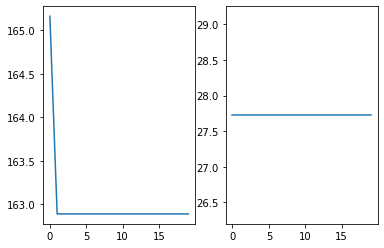

In [41]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(train_history)
axs[1].plot(test_history)

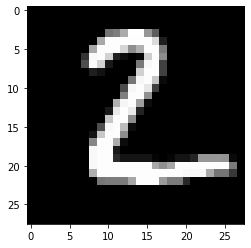

In [42]:
plt.imshow(np.squeeze(single_image), cmap="gray")

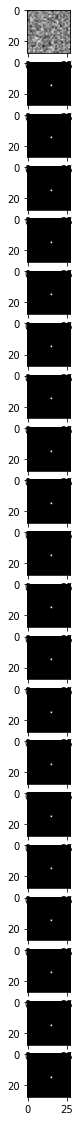

In [43]:
fig, axs = plt.subplots(len(single_image_hist), figsize = (2, 20))
for i, img in enumerate(single_image_hist):
    axs[i].imshow(np.squeeze(img), cmap="gray")